## Load Data from GDrive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/dataset.zip"

Archive:  /content/drive/MyDrive/dataset.zip
   creating: dataset/
   creating: dataset/test/
  inflating: dataset/test/TCGA-HU-A4GY-11A-01-TS1.63A3B7C0-63D1-4A3C-8325-79A4513A81BA_aug_0.png  
  inflating: dataset/test/TCGA-D7-8572-01A-01-TS1.82bad051-98fe-4b93-bcb6-2700c45e825e_aug_2.png  
  inflating: dataset/test/TCGA-V5-AASX-01A-01-TS1.0E65F14D-AF31-47A3-9CD1-DEEF104B666A_aug_9.png  
  inflating: dataset/test/TCGA-IG-A5S3-01A-01-TSA.0F1D563E-E7BA-4960-ABE7-AE05B9B3E538_aug_9.png  
  inflating: dataset/test/TCGA-BR-6457-11A-01-TS1.392499ee-61c9-4c26-801a-cdaf95e3e258_aug_1.png  
  inflating: dataset/test/TCGA-FP-7916-01Z-00-DX1.6264d8c6-0ddb-4905-ad0c-146e380ddee1_aug_2.png  
  inflating: dataset/test/TCGA-IG-A8O2-01A-01-TSA.9EEBA012-48B5-43E5-A154-D082B21D3B75_aug_4.png  
  inflating: dataset/test/TCGA-VR-AA4D-01A-01-TS1.F684C8CF-D1A7-4BAF-B32A-98BABEBD9472_aug_5.png  
  inflating: dataset/test/TCGA-LN-A4A2-01Z-00-DX1.41B9C9F4-C350-4FDF-A894-F23DDD6D3898_aug_8.png  
  inflating: da

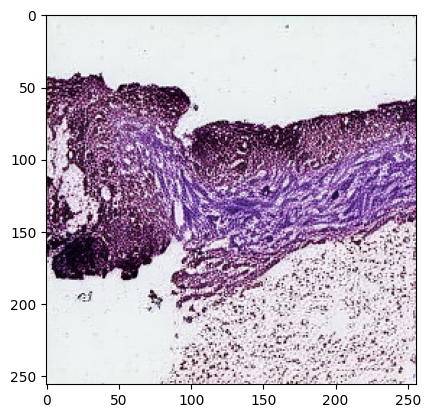

In [3]:
import cv2
import matplotlib.pyplot as plt
img = cv2.imread("/content/dataset/train/TCGA-2H-A9GF-01A-01-TS1.AE2090EE-B101-4F35-90F7-9D1B37BED787_aug_0.png")
plt.imshow(img)

## Data Preparation Utility

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
import os
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

In [5]:
def add_gaussian_noise(image, mean=0.0, stddev=0.05):
    noise = tf.random.normal(shape=tf.shape(image), mean=mean, stddev=stddev)
    image = tf.clip_by_value(image + noise, 0.0, 1.0)
    return image

def add_speckle_noise(image):
    noise = tf.random.normal(shape=tf.shape(image))
    image = tf.clip_by_value(image + image * noise, 0.0, 1.0)
    return image

def add_salt_and_pepper_noise(image, salt_prob=0.02, pepper_prob=0.02):
    rnd = tf.random.uniform(tf.shape(image), 0.0, 1.0)
    image = tf.where(rnd < pepper_prob, 0.0, image)
    image = tf.where(rnd > 1 - salt_prob, 1.0, image)
    return image

def apply_random_noise(image):
    r = tf.random.uniform([], 0, 3, dtype=tf.int32)
    return tf.switch_case(
        r,
        branch_fns={
            0: lambda: add_gaussian_noise(image),
            1: lambda: add_speckle_noise(image),
            2: lambda: add_salt_and_pepper_noise(image),
        },
        default=lambda: image,
    )

## Data Loader

In [6]:
def create_tf_dataset_from_csv(split_name, base_dir, batch_size=8):
    """Create TensorFlow dataset from CSV label files"""

    labels_path = os.path.join(base_dir, f"{split_name}.csv")

    images_dir = os.path.join(base_dir,split_name)

    # Read CSV file
    labels_df = pd.read_csv(labels_path)

    # Get unique class names and create a mapping
    unique_labels = sorted(labels_df['label'].unique())
    label_to_index = {label: i for i, label in enumerate(unique_labels)}

    def load_and_preprocess_image(filename, label):
        image_path = tf.strings.join([images_dir, filename], separator='/')
        image = tf.io.read_file(image_path)
        image = tf.image.decode_image(image, channels=3, expand_animations=False)
        image = tf.image.resize(image, [256, 256])
        image = tf.cast(image, tf.float32) / 255.0
        return image, label

    filenames = labels_df['image_name'].values
    string_labels = labels_df['label'].values
    # Convert string labels to numerical indices
    numerical_labels = np.array([label_to_index[label] for label in string_labels])

    dataset = tf.data.Dataset.from_tensor_slices((filenames, numerical_labels))
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

    if split_name == "train":
        dataset = dataset.shuffle(len(filenames))
        dataset = dataset.map(lambda x, y: (apply_random_noise(x), y), num_parallel_calls=tf.data.AUTOTUNE)


    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset, unique_labels

print("✅ Data loading function defined with balanced labels support!")

✅ Data loading function defined with balanced labels support!


## Model Definition

In [7]:
# Enable mixed precision globally
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [15]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

def build_model(input_shape=(224, 224, 3), num_classes=3):
    inputs = Input(shape=input_shape)

    # Load VGG16 as feature extractor
    base_model = tf.keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_tensor=inputs
    )

    # Optionally freeze the base
    base_model.trainable = False

    # unfreeze top 4
    for layer in base_model.layers[-4:]:
        layer.trainable = True

    # Add pooling + classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax', dtype='float32', name="classification")(x)

    model = Model(inputs, outputs, name="ResNet50")
    return model

## Dataset Prepartion

In [9]:
print("🚀 Loading datasets and analyzing...")
base_dir="dataset"

# Load datasets - these now return numerical labels
train_dataset, unique_labels = create_tf_dataset_from_csv("train", base_dir)
val_dataset, _ = create_tf_dataset_from_csv("val", base_dir)
test_dataset, _ = create_tf_dataset_from_csv("test", base_dir)

# FIX: Use the same numerical labels for class weights
train_labels_df = pd.read_csv(os.path.join(base_dir, "train.csv"))

# Convert to numerical labels using the same mapping
label_to_index = {label: i for i, label in enumerate(unique_labels)}
train_numerical_labels = np.array([label_to_index[label] for label in train_labels_df['label']])

# Calculate class weights using NUMERICAL labels
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_numerical_labels),
    y=train_numerical_labels
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

num_classes = len(unique_labels)
class_names = unique_labels  # Use actual label names instead of Class_0, Class_1, etc.

print(f"\n📊 Dataset Summary:")
print(f"  Training patches: {len(train_labels_df)}")
print(f"  Validation patches: {len(pd.read_csv(os.path.join(base_dir, 'val.csv')))}")
print(f"  Test patches: {len(pd.read_csv(os.path.join(base_dir, 'test.csv')))}")
print(f"  Number of classes: {num_classes}")
print(f"  Class names: {class_names}")
print(f"  Class weights: {class_weight_dict}")

# Show sample batch
sample_batch = next(iter(train_dataset))
images, labels = sample_batch
print(f"\n📐 Sample batch shape: {images.shape}")
print(f"🏷️ Sample labels: {labels.numpy()[:10]}")  # First 10 labels
print(f"🔢 Label mapping: {label_to_index}")

🚀 Loading datasets and analyzing...

📊 Dataset Summary:
  Training patches: 2204
  Validation patches: 472
  Test patches: 473
  Number of classes: 3
  Class names: ['Esophageal Adenocarcinoma', 'Esophageal Squamous Cell Carcinoma', 'Esophagogastric Cancer']
  Class weights: {0: np.float64(0.9834895136099956), 1: np.float64(0.9666666666666667), 2: np.float64(1.0540411286465805)}

📐 Sample batch shape: (8, 256, 256, 3)
🏷️ Sample labels: [2 0 2 1 1 0 0 0]
🔢 Label mapping: {'Esophageal Adenocarcinoma': 0, 'Esophageal Squamous Cell Carcinoma': 1, 'Esophagogastric Cancer': 2}


## Training Loop Utility

In [12]:
def compile_and_train_model(model, train_ds, val_ds, class_weights, epochs=100, learning_rate=1e-4,
                            checkpoint_path='best_model.keras', resume_from_checkpoint=None):
    # Compile model
    optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy', 'sparse_categorical_crossentropy']
    )

    # Resume from checkpoint if provided
    initial_epoch = 0
    if resume_from_checkpoint and os.path.exists(resume_from_checkpoint):
        print(f"📂 Resuming from checkpoint: {resume_from_checkpoint}")
        model.load_weights(resume_from_checkpoint)

        # Try to load epoch from training log
        if os.path.exists('training_log.csv'):
            log_df = pd.read_csv('training_log.csv')
            initial_epoch = len(log_df)
            print(f"Resuming from epoch {initial_epoch}")
        else:
            print(f"⚠️ No training log found, starting from epoch 0")
    else:
        print("🆕 Starting fresh training")

    # Callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            min_delta=0.01,
            patience=9,
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.90,
            patience=3,
            min_lr=1e-6,
            verbose=1
        ),
        tf.keras.callbacks.ModelCheckpoint(
            checkpoint_path,
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        tf.keras.callbacks.CSVLogger(
            'training_log.csv',
            append=True if resume_from_checkpoint else False
        )
    ]

    print(f"🎯 Training from epoch {initial_epoch} to {epochs}...")

    history = model.fit(
        train_ds,
        epochs=epochs,
        initial_epoch=initial_epoch,
        validation_data=val_ds,
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=1
    )

    return history, model

print("✅ Training function with checkpoint resume support defined!")

✅ Training function with checkpoint resume support defined!


## Model Training

In [16]:
print("🔨 Building model...")
model = build_model(input_shape=(256, 256, 3), num_classes=3)

print("\n📋 Model Summary:")
model.summary()

print(f"\n🧮 Model Parameters:")
print(f"  Total parameters: {model.count_params():,}")

print(f"\n✅ Model built successfully!")

🔨 Building model...

📋 Model Summary:


Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 23,593,859 (90.00 MB)

 Trainable params: 1,060,867 (4.05 MB)

 Non-trainable params: 22,532,992 (85.96 MB)


🧮 Model Parameters:
  Total parameters: 23,593,859

✅ Model built successfully!


In [17]:
print("🎯 Starting model training with 100 epochs...")
print("You'll see training loss and validation accuracy for each epoch:\n")

history, trained_model = compile_and_train_model(
    model, train_dataset, val_dataset, class_weight_dict, epochs=50, learning_rate=1e-4,
)

print("\n✅ Training completed!")

🎯 Starting model training with 100 epochs...
You'll see training loss and validation accuracy for each epoch:

🆕 Starting fresh training
🎯 Training from epoch 0 to 50...
Epoch 1/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.4402 - loss: 1.0785 - sparse_categorical_crossentropy: 1.0798
Epoch 1: val_accuracy improved from -inf to 0.49364, saving model to best_model.keras
276/276 ━━━━━━━━━━━━━━━━━━━━ 71s 108ms/step - accuracy: 0.4403 - loss: 1.0783 - sparse_categorical_crossentropy: 1.0797 - val_accuracy: 0.4936 - val_loss: 1.0895 - val_sparse_categorical_crossentropy: 1.0895 - learning_rate: 1.0000e-04
Epoch 2/50
275/276 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5070 - loss: 1.0013 - sparse_categorical_crossentropy: 1.0006
Epoch 2: val_accuracy improved from 0.49364 to 0.54025, saving model to best_model.keras
276/276 ━━━━━━━━━━━━━━━━━━━━ 49s 74ms/step - accuracy: 0.5070 - loss: 1.0012 - sparse_categorical_crossentropy: 1.0005 - val_accuracy: 0.5403 - val_loss: 1.0050 

## Model Evaluation

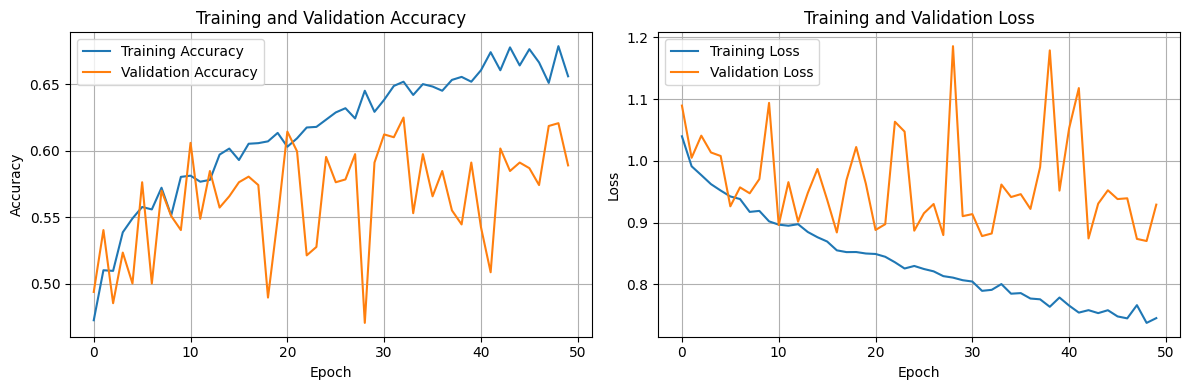

In [18]:
# Plotting training history
def plot_history(history):
    """Plots training history"""
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Plot the history from the initial training run
plot_history(history)

# If you continued training with additional_history, you can plot that as well
# plot_history(additional_history)

In [19]:
model.load_weights('best_model.keras')


📈 EVALUATING CURRENT MODEL:
Test Accuracy: 0.5962
Test Loss: 0.8740

📊 Classification Report:
                                    precision    recall  f1-score   support

         Esophageal Adenocarcinoma       0.56      0.67      0.61       154
Esophageal Squamous Cell Carcinoma       0.65      0.54      0.59       162
            Esophagogastric Cancer       0.59      0.58      0.59       157

                          accuracy                           0.60       473
                         macro avg       0.60      0.60      0.60       473
                      weighted avg       0.60      0.60      0.60       473



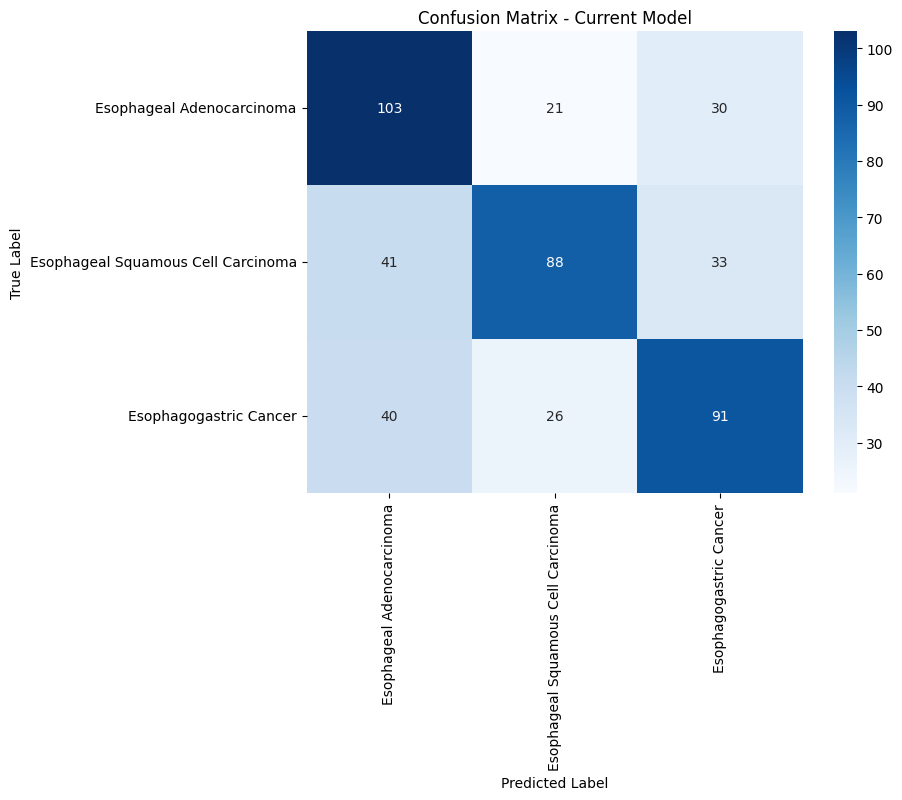

In [20]:
def evaluate_current_model(model, test_dataset, class_names):
    """Evaluate the current model performance"""
    print("\n📈 EVALUATING CURRENT MODEL:")
    print("=" * 40)

    # Test accuracy
    test_loss, test_accuracy, _ = model.evaluate(test_dataset, verbose=0)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

    # Detailed predictions
    y_true = []
    y_pred = []

    for images, labels in test_dataset:
        predictions = model.predict(images, verbose=0)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(predictions, axis=1))

    print(f"\n📊 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix - Current Model')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return test_accuracy

# Evaluate current model
current_accuracy = evaluate_current_model(model, test_dataset, class_names)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import label_binarize
import numpy as np

def plot_roc_curves(model, test_dataset, class_names):
    """Plot ROC curves for multi-class classification"""

    # Get true labels and predictions
    y_true = []
    y_pred_proba = []

    for images, labels in test_dataset:
        y_true.extend(labels.numpy())
        y_pred_proba.extend(model.predict(images, verbose=0))

    y_true = np.array(y_true)
    y_pred_proba = np.array(y_pred_proba)

    # Binarize labels for multi-class ROC
    y_true_bin = label_binarize(y_true, classes=range(len(class_names)))

    # Compute ROC curve and ROC area for each class
    fpr = {}
    tpr = {}
    roc_auc = {}

    plt.figure(figsize=(10, 8))

    for i, class_name in enumerate(class_names):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

        plt.plot(fpr[i], tpr[i],
                label=f'{class_name} (AUC = {roc_auc[i]:.3f})',
                linewidth=2)

    # Plot diagonal line
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curves')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

    # Print AUC scores
    print("AUC Scores:")
    for i, class_name in enumerate(class_names):
        print(f"  {class_name}: {roc_auc[i]:.4f}")

    return y_true, y_pred_proba

# Usage after training:
y_true, y_pred_proba = plot_roc_curves(model, test_dataset, class_names)